In [ ]:
!pip install hypernetx
!pip install celluloid
!pip install igraph

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import hypernetx as hnx

import itertools
import numpy as np
import scipy.special

import numba

In [ ]:
def generate_H(n, k):
    H = dict()
    i = 0
    alpha = 20 / n**2
    p = 3/4
    q = 1 - p
    for edge in itertools.combinations(range(n//2), k):
        coin = np.random.binomial(1, p * alpha)
        if coin:
            H[i] = edge
            H[i] = list(map(str, H[i]))
            i += 1
    
    for edge in itertools.combinations(range(n//2, n), k):
        coin = np.random.binomial(1, p * alpha)
        if coin:
            H[i] = edge
            H[i] = list(map(str, H[i]))
            i += 1

    for edge1 in itertools.combinations(range(n//2), k//2):
        for edge2 in itertools.combinations(range(n//2, n), k//2):
            coin = np.random.binomial(1, q * alpha)
            if coin:
                H[i] = edge1 + edge2
                H[i] = list(map(str, H[i]))
                i += 1

    return H

In [ ]:
def ComputeSimilarityMatrix(n, d, edges, c):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            weight = 0
            if i != j:
                for idx in edges:
                    edge = edges[idx]
                    if (str(i) in edge) and (str(j) in edge):
                        weight += 1

            A[i, j] = weight
            A[j, i] = weight

    A0 = A.copy()
    A0[A.sum(-1) > (c / n) * A.sum()] = np.zeros((1, n))
    A0[:, A.sum(0) > (c / n) * A.sum()] = np.zeros((n, 1))
    return A0

In [ ]:
d = 4
n = 30
edges = generate_H(n, d)

In [ ]:
H = hnx.Hypergraph(edges)
hnx.draw(H)

In [ ]:
A0 = ComputeSimilarityMatrix(n, d, edges, 6)

In [ ]:
from scipy.linalg import eigh
from scipy.cluster.vq import vq, kmeans, whiten
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def HSC(A):
    ''' 
        A - processed similarity matrix
    '''

    w, v = eigh(A)
    U = v[:, -2:]
    # scaler = StandardScaler()
    # scaled_features = scaler.fit_transform(U)
    kmeans = KMeans(n_clusters=2, max_iter=1000, tol=1e-6, random_state=0).fit(U)
    return kmeans.labels_

def compute_metrics(n, labels):
    acc1 = (labels[:n//2] == 1).sum() / n
    acc2 = (labels[n//2:] == 0).sum() / n

    return acc1 + acc2

In [ ]:
labels = HSC(A0)

In [ ]:
compute_metrics(n, labels)

0.06666666666666667

In [ ]:
def GenerateHWeighted(n, k, p, q, alpha):
    H = list()
    W = list()
    i = 0
    # alpha = 7 * np.log(n) / n**2
    # p = 3/4
    # q = 1 - p
    for edge in itertools.combinations(range(n//2), k):
        coin = p * np.random.binomial(1, alpha)
        if coin:
            H.append(list(edge))
            W.append(coin)
            i += 1
    
    for edge in itertools.combinations(range(n//2, n), k):
        coin = p * np.random.binomial(1, alpha)
        if coin:
            H.append(list(edge))
            W.append(coin)
            i += 1

    for edge1 in itertools.combinations(range(n//2), k//2):
        for edge2 in itertools.combinations(range(n//2, n), k//2):
            coin = q * np.random.binomial(1, alpha)
            if coin:
                H.append(list(edge1) + list(edge2))
                W.append(coin)
                i += 1

    return H, W

In [ ]:
def ComputeSimilarityMatrixWeighted(n, d, edges, W, c):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            weight = 0
            if i != j:
                for idx in range(len(edges)):
                    edge = edges[idx]
                    if (i in edge) and (j in edge):
                        weight += W[idx]

            A[i, j] = weight
            A[j, i] = weight

    A0 = A.copy()
    A0[A.sum(-1) > (c / n) * A.sum()] = np.zeros((1, n))
    A0[:, A.sum(0) > (c / n) * A.sum()] = np.zeros((n, 1))
    return A0

In [ ]:
def HSCLR(n, edges, W, beta):
    E1 = list()
    E2 = list()
    W1 = list()
    W2 = list()

    for idx in range(len(edges)):
        edge = edges[idx]
        coin = np.random.binomial(1, beta)
        if coin:
            E1.append(edge)
            W1.append(W[idx])
        else:
            E2.append(edge)
            W2.append(W[idx])

    A0 = ComputeSimilarityMatrixWeighted(n, d, E1, W1, 6)
    labels = HSC(A0)
    res_labels = np.zeros(labels.size)
    for i in range(n):
        mx_label = labels[i]
        mx_val = -1e9
        for label in range(2):
            weight = 0
            cnt_elems = 0
            for idx in range(len(E2)):
                edge = E2[idx]
                if i not in edge:
                    continue

                flag = True
                for t in edge:
                    if (t != i) and (labels[t] == label):
                        continue
                    
                    flag = False
                
                if flag:
                    cnt_elems += 1
                    weight += W2[idx]
            
            if cnt_elems and weight / cnt_elems > mx_val:
                print('!!!!!!!!!')
                mx_val = weight / cnt_elems
                mx_label = label
        
        res_labels[i] = mx_label

    return res_labels

In [ ]:
alphas = np.linspace(1, 12, 10)
betas = np.linspace(1, 12, 10) + 2
vals = np.zeros((10, 10))
d = 4
n = 50
for i, alpha in enumerate(alphas):
    print(i)
    for j, beta in enumerate(betas):
        p = alpha * (np.log(n) / n)
        q = beta * (np.log(n) / n)
        cnst = (p * 16) / (p - q)**2
        best_alpha = cnst * np.log(n) / n**3
        edges, W = GenerateHWeighted(n, d, p, q, best_alpha)
        labels = HSCLR(n, edges, W, np.log(np.log(n)) / np.log(n))
        vals[i, j] = compute_metrics(n, labels)
        if vals[i, j] < 0.5:
            vals[i, j] = 1 - vals[i, j]

0
1
2
3
4
5
6
7
8
9


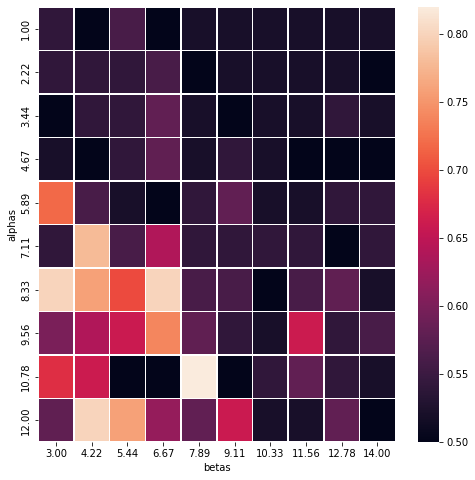

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

xlabels = ['{:,.2f}'.format(b) for b in betas]
ylabels = ['{:,.2f}'.format(a) for a in alphas]
x_axis_labels = xlabels
y_axis_labels = ylabels
ax = sns.heatmap(vals, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=0.5)
ax.set(xlabel='betas', ylabel='alphas')
ax.figure.savefig('heatmap')

In [ ]:
d = 4
n = 50
p = 3/4
q = 1/4
cnst = (p * 16) / (p - q)**2
best_alpha = cnst * np.log(n) / n**3
print(best_alpha)
alphas = np.linspace(0, 0.03, 30)
metrics = list()
for alpha in alphas:
    print(alpha)
    edges, W = GenerateHWeighted(n, d, p, q, alpha)
    labels = HSCLR(n, edges, W, np.log(np.log(n)) / np.log(n))
    metric = compute_metrics(n, labels)
    if metric < 0.5:
        metric = 1 - metric
    metrics.append(metric)

0.0015022168340844079
0.0
0.0010344827586206897
0.0020689655172413794
0.0031034482758620693
0.004137931034482759
0.005172413793103448
0.0062068965517241385
0.007241379310344828
0.008275862068965517
0.009310344827586208
0.010344827586206896
0.011379310344827587
0.012413793103448277
0.013448275862068966
0.014482758620689656
0.015517241379310345
0.016551724137931035
0.017586206896551725
0.018620689655172416
0.019655172413793102
0.020689655172413793
0.021724137931034483
0.022758620689655173
0.023793103448275864
0.024827586206896554
0.02586206896551724
0.02689655172413793
0.02793103448275862
0.028965517241379312
0.03


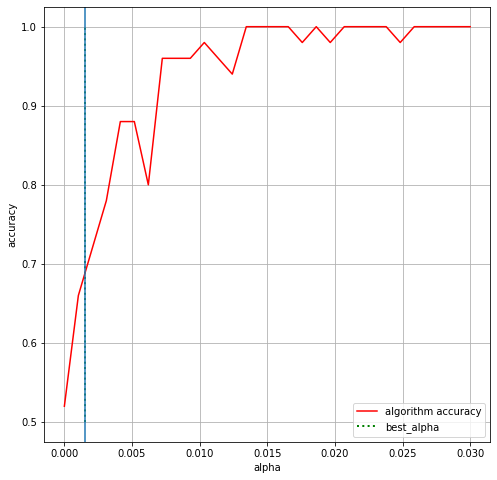

In [ ]:
plt.plot(alphas, metrics, 'r', label='algorithm accuracy')
plt.axvline(x=best_alpha)
plt.vlines(x=best_alpha, ymin=0.5, ymax=1, color='green', ls=':', lw=2, label='best_alpha')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.savefig('accuracy_thres')
# plt.show()

In [ ]:
import tensor
import tensor_utils

d = 4
n = 100
p = 3/4
q = 1/4
cnst = (p * 16) / (p - q)**2
best_alpha = cnst * np.log(n) / n**2
score_dan = 0
score_my = 0
for i in range(10):
    print(i)
    edges, W = GenerateHWeighted(n, d, p, q, best_alpha)
    labels_my = HSCLR(n, edges, W, np.log(np.log(n)) / np.log(n))
    np.save('edges' + str(i), edges)
    np.save('weights' + str(i), W)
    my = compute_metrics(n, labels_my)
    if my < 0.5:
        my = 1 - my
    edges = np.array(edges)
    W = np.array(W)
    X, _, _ = tensor.laplacian_tensor_clustering(edges, W, n)
    labels_danya = tensor.get_clusters(X)
    dan = compute_metrics(n, labels_my)
    if dan < 0.5:
        dan = 1 - dan

    score_dan += dan
    score_my += my

print('Accuracy for laplacian_tensor_clustering:', score_dan / 10)
print('Accuracy for HSCLR:', score_my / 10)

0
1
2
3
4
5
6
7
8
9
Accuracy for laplacian_tensor_clustering: 1.0
Accuracy for HSCLR: 1.0


In [ ]:
import tensor
import tensor_utils

d = 4
n = 100
p = 0.2763102111592855
q = 0.9210340371976184
cnst = (p * 16) / (p - q)**2
best_alpha = cnst * np.log(n) / n**2
score_dan = 0
score_my = 0
for i in range(10):
    print(i)
    edges, W = GenerateHWeighted(n, d, p, q, best_alpha)
    labels_my = HSCLR(n, edges, W, np.log(np.log(n)) / np.log(n))
    np.save('edges' + str(i), edges)
    np.save('weights' + str(i), W)
    my = compute_metrics(n, labels_my)
    if my < 0.5:
        my = 1 - my
    edges = np.array(edges)
    W = np.array(W)
    X, _, _ = tensor.laplacian_tensor_clustering(edges, W, n)
    labels_danya = tensor.get_clusters(X)
    dan = compute_metrics(n, labels_my)
    if dan < 0.5:
        dan = 1 - dan

    score_dan += dan
    score_my += my

print('Accuracy for laplacian_tensor_clustering:', score_dan / 10)
print('Accuracy for HSCLR:', score_my / 10)

0
1
2
3
4
5
6
7
8
9
Accuracy for laplacian_tensor_clustering: 0.5499999999999999
Accuracy for HSCLR: 0.5499999999999999
